In [28]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import pickle
import numpy as np

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {index : name for index, name in zip(iM_table.index, iM_table.name)}
M = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
A = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = k_to_iM)

# pull in flags_df and limit to iMs listed
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
flags_df = flags_df[flags_df['include'] == True]




# loading
# merge together log_tpm_df files
#log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {index : name for index, name in zip(iM_table.index, iM_table.name)}
M_df = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
overlap = list(set(M_df.index).intersection(log_tpm_df.index))
M_df = M_df.loc[overlap]
log_tpm_df = log_tpm_df.loc[overlap]


#iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
#M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

#zerod_M = zerod_M.drop(columns = ['fps__fps_ptsI_ale3__1', 'fps__fps_ptsI_ale3__2', 'fps__fps_ptsI_ale1__1', 'fps__fps_ptsI_ale1__2'])

# Calculate the inverse of DataFrame M
M_inverse = pd.DataFrame(np.linalg.pinv(zerod_M.values), zerod_M.columns, zerod_M.index)

# Solve for DataFrame A: A = M_inverse * X
#fixed_X = log_tpm_df.div(log_tpm_df[basal_conditions].mean(axis = 1), axis = 'index')
fixed_X = log_tpm_df.sub(log_tpm_df[['p1k_00001', 'p1k_00002']].mean(axis = 1), axis = 'index')
to_drop = list(set(['fps__fps_ptsI_ale3__1', 'fps__fps_ptsI_ale3__2', 'fps__fps_ptsI_ale1__1', 'fps__fps_ptsI_ale1__2']).intersection(set(fixed_X.columns)))
fixed_X = fixed_X.fillna(0).drop(columns = to_drop)
A_df = M_inverse.dot(fixed_X)

In [2]:
# settings loading data
# settings
case = 'Arginine'
metabolites = ['Arginine']#['Guanine', 'Hypoxanthine']
act_iM = None
inh_iM = 'Arginine'
plot_gene = 'argA'
plot_regulator = 'argR'

if True:
    true_false = []
    for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
        if act in [case] or inh in [case]:
            true_false.append(True)
        else:
            true_false.append(False)
    bby_flags_df = flags_df.loc[true_false]

    # load in relevant data
    starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
    # above is in (µM) , convert to M
    starve_metabs[starve_metabs.columns[1:]] *= 1e-6
    starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
    #starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

    iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
    run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    metab_df = inh_metab_df[inh_metab_df['iM'] == case]
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)



    # grab genes
    genes = cInh_mapping[cInh_mapping[inh_iM] != 0].index.to_list()

    # load in for loop
    calc_cInh = GAMS_calc_cInh[genes]
    calc_cAct = GAMS_calc_cAct[genes]
    mRNA_ratio_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0).loc[calc_cInh.index]


    # creating actual and reconstructed mRNA values
    all_shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)).intersection(ratios_df.index[ratios_df[gene].notnull()]))

        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        #po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))
        pickle_in = open('../data/lambda_dfs/'+gene+'.pkl', 'rb')
        lambda_df = pickle.load(pickle_in)
        pickle_in.close()

        recon_mRNA = []
        for sample in shared:
            cAct = calc_cAct[gene].loc[sample]
            cInh = calc_cInh[gene].loc[sample]
            lambda_df1 = lambda_df[gene].loc[sample]
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = lambda_df1))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)

    # save recon
    recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = all_shared)
    actual_df = pd.DataFrame(actual_mRNAs, index = indices_for_recons, columns = all_shared)

In [ ]:
# let's plot metaboltie concentration

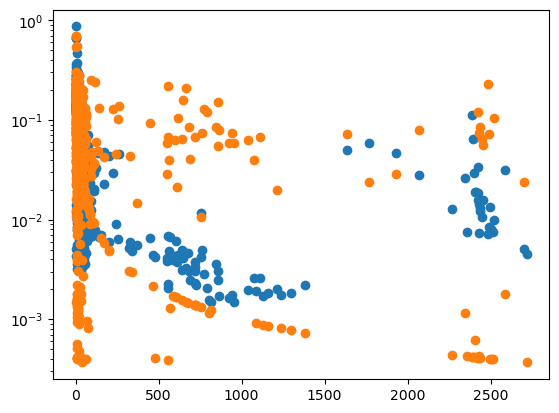

In [5]:
# GARBAGE plotting

plt.scatter(calc_cInh[gene_to_b[plot_gene]], mRNA_ratio_df[gene_to_b[plot_gene]])
plt.scatter(calc_cInh[gene_to_b[plot_gene]], recon_df[mRNA_ratio_df.index].loc[gene_to_b[plot_gene]])
plt.yscale('log')
plt.show()

In [25]:
log_tpm_df.loc[expression]

starve_series__t00_growth1    10.491118
starve_series__t01_starve      9.989401
starve_series__t02_starve      8.739943
starve_series__t03_starve      9.435713
starve_series__t04_starve      9.528686
                                ...    
p1k_01051                     10.632434
p1k_01052                      9.618533
p1k_01053                     10.280260
p1k_01054                      9.039474
p1k_01055                      9.398956
Name: b1101, Length: 1079, dtype: float64

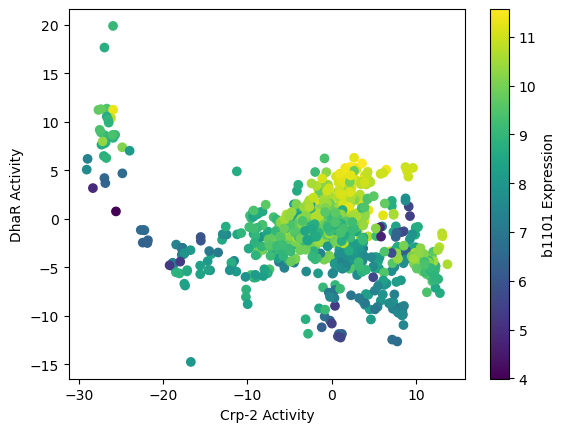

In [48]:
# 2iM figure - let's plot everything that feeds in to show the trend we are trying to plot
drop_stationary = True
iM1_activity = 'Crp-2'
iM2_activity = 'DhaR'
expression = 'b1101'


cols_use = log_tpm_df.columns.to_list()
if drop_stationary:
    new_cols = []
    for col in cols_use:
        if 'starve' not in col:
            new_cols.append(col)
    cols_use = new_cols

color_set = log_tpm_df.loc[expression][cols_use]
# Define colormap and normalization
cmap = cm.viridis  # You can choose any other colormap
normalize = plt.Normalize(vmin=min(color_set), vmax=max(color_set))
# Plotting
fig, ax = plt.subplots()  # Add this line to create a figure and axes
sc = ax.scatter(A_df.loc[iM1_activity][cols_use], A_df.loc[iM2_activity][cols_use], c=color_set, cmap=cmap, norm=normalize)

# Add color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(expression+' Expression')

plt.xlabel(iM1_activity+' Activity')
plt.ylabel(iM2_activity+' Activity')
plt.savefig('../figures/trained_on.pdf', transparent = True)
plt.show()